<h1>AutomationDirect P3-530 PLC</h1>

This device is a programmable logic controller. The firmware can be found here:

https://ftp.automationdirect.com/firmware/FirmwareOnly/P3-530_1.2.7.39.adfw

When unpacked with Binwalk, there are several binary files that can be analyzed. The file analyzed here is `P3_530.bin`. When a signature scan of this file is run, the output is as follows:

```
$ binwalk P3_530.bin 

DECIMAL       HEXADECIMAL     DESCRIPTION
--------------------------------------------------------------------------------
1140488       0x116708        Copyright string: "Copyright MGC 2003 - Nucleus PLUS - MPC824x Metrowerks v. 1.14"
1141840       0x116C50        Base64 standard index table
1143036       0x1170FC        HTML document header
1157304       0x11A8B8        DES SP1, big endian
1157560       0x11A9B8        DES SP2, big endian
1160064       0x11B380        SHA256 hash constants, big endian
1225624       0x12B398        CRC32 polynomial table, big endian
1300760       0x13D918        HTML document header
1301521       0x13DC11        HTML document footer
1301644       0x13DC8C        HTML document header
1301793       0x13DD21        HTML document footer
1301804       0x13DD2C        HTML document header
1301892       0x13DD84        HTML document footer
1313328       0x140A30        HTML document header
1314231       0x140DB7        HTML document footer
1314532       0x140EE4        HTML document header
1315095       0x141117        HTML document footer
1315104       0x141120        HTML document header
1315182       0x14116E        HTML document footer
1315192       0x141178        HTML document header
1315279       0x1411CF        HTML document footer
1319268       0x142164        PEM certificate
1319324       0x14219C        PEM certificate request
1319512       0x142258        PEM RSA private key
1319708       0x14231C        PEM EC private key
1319776       0x142360        PEM DSA private key

```

Time to use Centrifuge.

In [1]:
import sys
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]  

sys.path[0:0] = ['.', '..']

from centrifuge.binfile import BinFile

In [2]:
file_handle = open("_P3-530_1.2.7.39.adfw.extracted/P3_530.bin", "rb")
plc_bin = BinFile(file_handle)
plc_bin.slice_file()

We can look at a couple of plots to get our bearings:

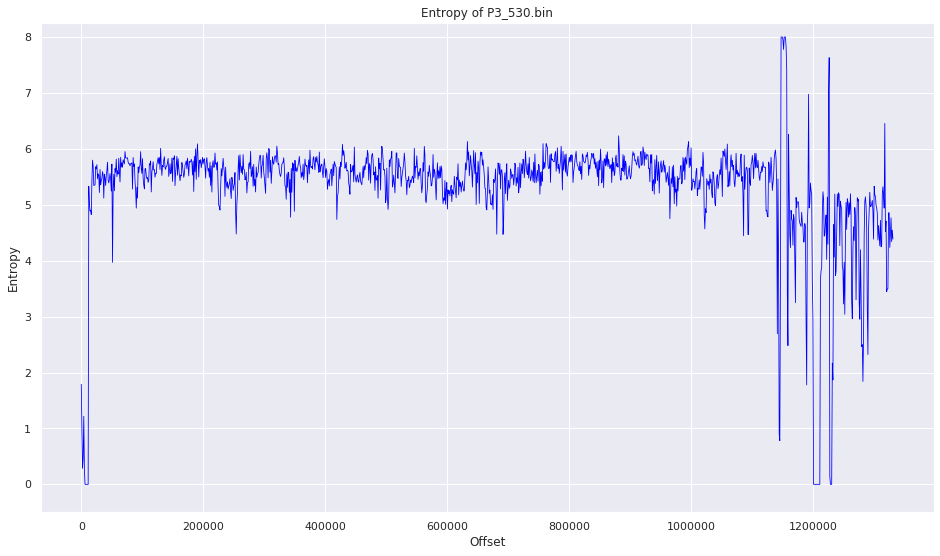

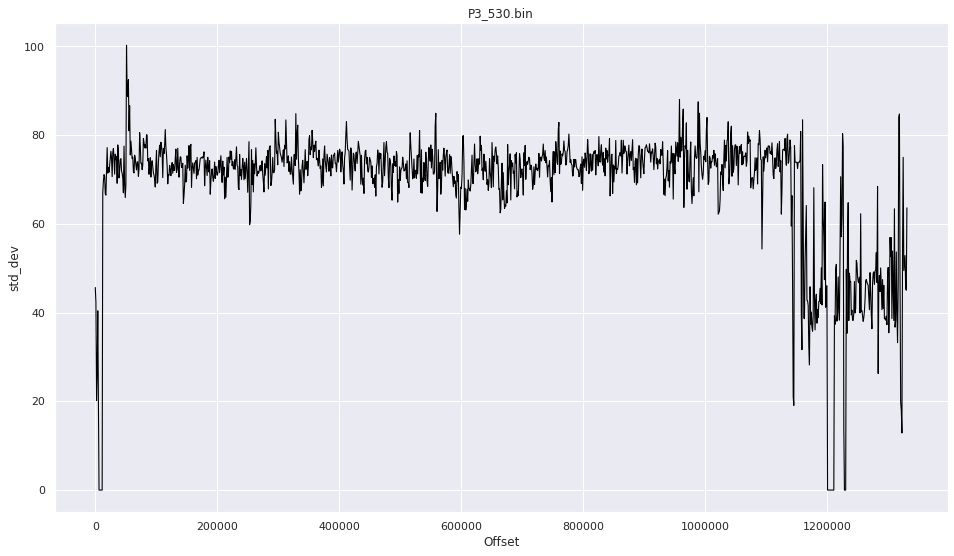

In [3]:
plc_bin.plot_file_entropy()
plc_bin.plot_file_feature("std_dev", "black")

There seem to be 2 large discrete areas with a few smaller ones. Let's see what can be found with clustering:

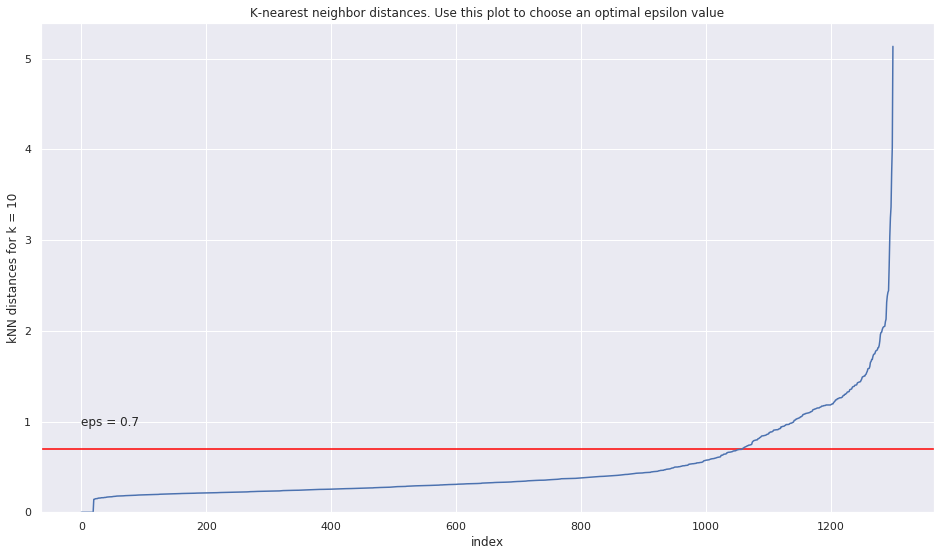

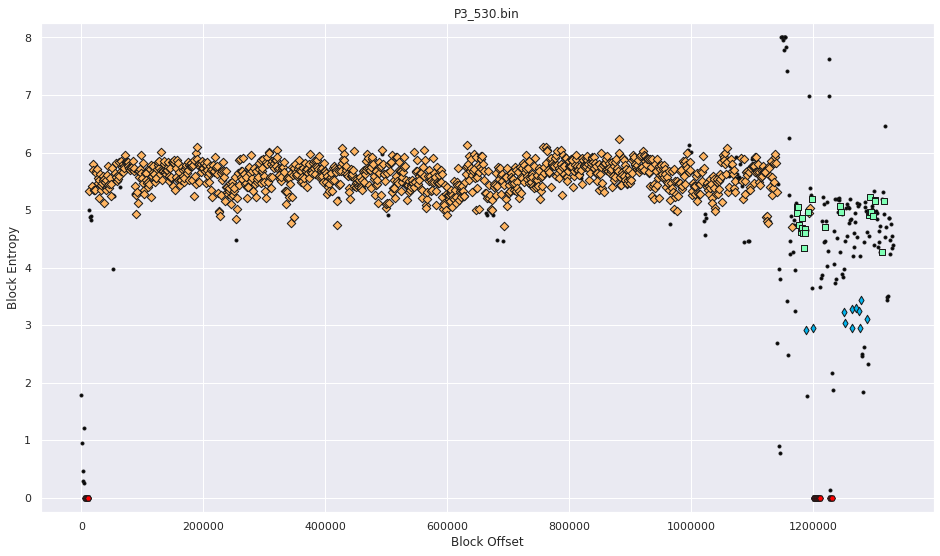

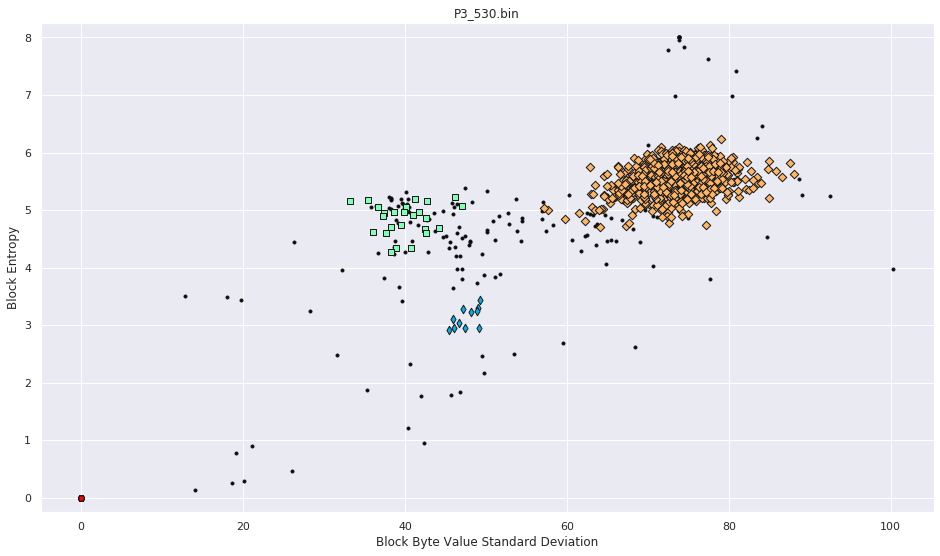

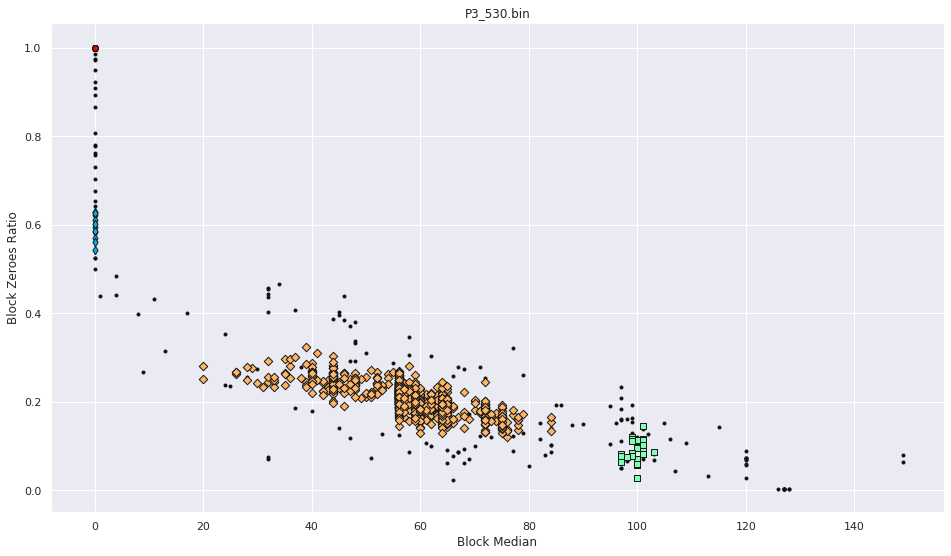

In [4]:
plc_bin.cluster_DBSCAN(epsilon=0.7,
                       minimum_samples=10,
                       find_optimal_epsilon=True)
plc_bin.plot_DBSCAN_results()

In [5]:
results = plc_bin.identify_cluster_data_types()

Searching for machine code
--------------------------------------------------------------------

[+] Checking Cluster 1 for possible match
[+] Closely matching CPU architecture reference(s) found for Cluster 1
[+] Sending sample to https://isadetect.com/
[+] response:

{
    "prediction": {
        "architecture": "powerpc",
        "endianness": "big",
        "wordsize": 32
    },
    "prediction_probability": 0.58
}


Searching for utf8-english data
-------------------------------------------------------------------

[+] UTF-8 (english) detected in Cluster 2
    Wasserstein distance to reference: 9.522864483173079


Searching for high entropy data
-------------------------------------------------------------------

[X] No high entropy data cluster detected.



Turns out that there is PowerPC machine code present. For fun, we can take a look at the UTF-8 data:

In [6]:
_, cluster_byte_values = plc_bin.extract_clusters()
bytes(cluster_byte_values[2])[:1000]

b'USER Cmd NU_Send failure.\r\n\x00\x00\x00\x00\x00Invalid task pointer.\r\n\x00Cannot get local server address info.\r\n\x00***** Unable to create FTP server Data_Task *****\r\n\x00\x00\x00\x00\x00***** Unable to Allocate Data_Task stack memory *****\r\n\x00***** Unable to allocate Data_Task control block memory.\r\n\x00\x00450 Requested file action not taken.\r\n\x00\x00FTPS_Server_Get() NU_Send failure.\r\n\x00\x00\x00\x00150 File status okay; about to open data connection.\r\n\x00\x00\x00\x00\x00\x00452 Requested action not taken: Insufficient storage space in system.\r\n\x00Unable to receive file contents. (NU_Recv() failed).\r\n\x00\x00426 Transfer aborted, closing control connection.\r\n\x00226 Closing data connection.  Requested file action successful.\r\n\x00\x00\x00550 Requested file action not taken.\r\n\x00\x00FTPS_Server_Put NU_Send failure.\r\n\x00\x00Unable to send file contents. (NU_Send() failed).\r\n\x00Data_Recv_Task NU_Send failure.\r\n\x00\x00\x00FTPS_Server_ChDir 

Full results:

In [7]:
results

{'machine code': [{'Cluster 0': 98.34206261111112,
   'Cluster 1': [22.67675572068486,
    {'MIPS64EL_reference': 13.590556504220379,
     'PowerPC_reference': 10.207836752660828,
     'i386_reference': 33.97814710454115,
     'ARMEL_reference': 39.78879260454116,
     'MIPSEL_reference': 8.325268822662904,
     'PPC64_reference': 24.771323316772115,
     'AMD64_reference': 30.040791104541157,
     'ARM64_reference': 28.835538604541142,
     'SH4_reference': 27.51206604955061}],
   'Cluster 2': 45.354132039162664,
   'Cluster 3': 63.37313505429293},
  {'prediction': {'wordsize': 32,
    'endianness': 'big',
    'architecture': 'powerpc'},
   'prediction_probability': 0.58}],
 'utf8_en': {'Cluster 0': 86.832,
  'Cluster 1': 42.07556968424785,
  'Cluster 2': 9.522864483173079,
  'Cluster 3': 51.93986079545455},
 'high entropy': {'Cluster 0': 127.41200000000002,
  'Cluster 1': 51.91337214699624,
  'Cluster 2': 47.12458082932692,
  'Cluster 3': 92.44307244318182}}